# import library


In [ ]:
import scipy
import numpy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.core.pylabtools import figsize

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

# Read Dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/christianbangarna/IDSL/main/IDSL-307_data.csv', parse_dates = ['Time(UTC)'], index_col = 'Time(UTC)') 
df

,Lev RAD (m),Panel (V),rms (m),Sensor Temp (C),Temperature (C),Alert,Alert Signal,Battery (V),Forecast 30 (m),Forecast 300 (m)
Time(UTC),,,,,,,,,,
2019-10-28 05:56:26,5.828,-5.5,0.000,58.0,63.184,0.0,0.012,13.140,5.710,5.723
2019-10-28 07:20:54,5.720,-5.5,0.118,59.1,62.432,0.0,0.058,12.736,5.596,5.653
2019-10-28 07:53:05,5.838,-5.5,0.137,59.1,60.473,0.0,0.083,12.756,5.605,5.688
2019-10-28 07:53:47,5.764,-5.5,0.136,59.1,60.308,0.0,0.113,12.747,5.575,5.688
2019-10-28 08:22:03,6.005,-5.5,0.112,58.0,57.597,0.0,0.023,12.675,5.851,5.874
...,...,...,...,...,...,...,...,...,...,...
2020-09-30 15:27:48,6.688,-5.5,0.027,52.6,45.272,0.0,0.024,12.225,6.633,6.658
2020-09-30 15:54:02,6.600,-5.5,0.022,52.6,45.101,0.0,0.005,12.216,6.552,6.548
2020-09-30 17:21:32,6.154,-5.5,0.025,52.6,45.062,0.0,0.010,12.188,6.165,6.155


In [ ]:
# Explore the first five rows
df.head()

,Lev RAD (m),Panel (V),rms (m),Sensor Temp (C),Temperature (C),Alert,Alert Signal,Battery (V),Forecast 30 (m),Forecast 300 (m)
Time(UTC),,,,,,,,,,
2019-10-28 05:56:26,5.828,-5.5,0.000,58.0,63.184,0.0,0.012,13.140,5.710,5.723
2019-10-28 07:20:54,5.720,-5.5,0.118,59.1,62.432,0.0,0.058,12.736,5.596,5.653
2019-10-28 07:53:05,5.838,-5.5,0.137,59.1,60.473,0.0,0.083,12.756,5.605,5.688
2019-10-28 07:53:47,5.764,-5.5,0.136,59.1,60.308,0.0,0.113,12.747,5.575,5.688
2019-10-28 08:22:03,6.005,-5.5,0.112,58.0,57.597,0.0,0.023,12.675,5.851,5.874


In [ ]:
# Data description
df.describe()

,Lev RAD (m),Panel (V),rms (m),Sensor Temp (C),Temperature (C),Alert,Alert Signal,Battery (V),Forecast 30 (m),Forecast 300 (m)
count,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.614755,-5.5,0.042958,53.989530,51.100149,0.004700,0.030515,12.498692,6.614565,6.614263
std,0.431511,0.0,0.087965,6.838731,11.124522,0.186766,0.034476,0.356772,0.429184,0.428094
min,5.464000,-5.5,0.000000,-1.000000,30.593000,0.000000,0.000000,11.812000,5.341000,5.329000
25%,6.298000,-5.5,0.024000,51.500000,42.373000,0.000000,0.010000,12.217000,6.300000,6.303750
50%,6.593000,-5.5,0.032000,53.700000,47.169000,0.000000,0.022000,12.351000,6.591000,6.592000
75%,6.921000,-5.5,0.044000,58.000000,58.940500,0.000000,0.041000,12.747000,6.919000,6.920000
max,8.043000,-5.5,3.033000,73.600000,84.692000,10.000000,1.232000,13.599000,8.018000,7.989000


In [ ]:
# Find number of rows and columns
df.shape

(10000, 10)

# Time Series Plot

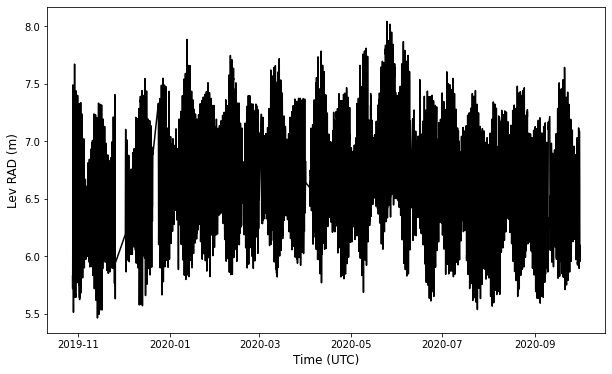

In [ ]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12})
    plt.ylabel(y_label, {'fontsize': 12})
    plt.savefig('/content/sample_data/1.jpg', format='jpg', dpi=1000)

timeseries(df.index, df['Lev RAD (m)'], 'Time (UTC)', 
           'Lev RAD (m)')

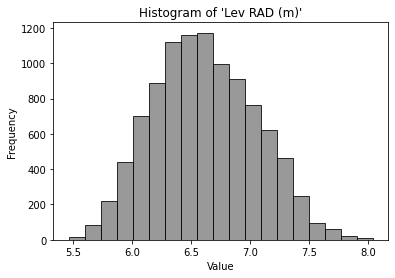

In [ ]:
def plot_histogram(x):
    plt.hist(x, bins = 19, alpha=0.8, color = 'gray', edgecolor = 'black')
    plt.title("Histogram of '{var_name}'".format(var_name=x.name))
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plot_histogram(df['Lev RAD (m)'])

# Data Preprocessing

In [ ]:
df = df.rename(columns = {'Lev RAD (m)':'RAD','Temperature (C)':'Temp', 'Sensor Temp (C)':'S_Temp', 
                          'rms (m)':'RMS','Forecast 30 (m)':'FC30'})

df

,RAD,Panel (V),RMS,S_Temp,Temp,Alert,Alert Signal,Battery (V),FC30,Forecast 300 (m)
Time(UTC),,,,,,,,,,
2019-10-28 05:56:26,5.828,-5.5,0.000,58.0,63.184,0.0,0.012,13.140,5.710,5.723
2019-10-28 07:20:54,5.720,-5.5,0.118,59.1,62.432,0.0,0.058,12.736,5.596,5.653
2019-10-28 07:53:05,5.838,-5.5,0.137,59.1,60.473,0.0,0.083,12.756,5.605,5.688
2019-10-28 07:53:47,5.764,-5.5,0.136,59.1,60.308,0.0,0.113,12.747,5.575,5.688
2019-10-28 08:22:03,6.005,-5.5,0.112,58.0,57.597,0.0,0.023,12.675,5.851,5.874
...,...,...,...,...,...,...,...,...,...,...
2020-09-30 15:27:48,6.688,-5.5,0.027,52.6,45.272,0.0,0.024,12.225,6.633,6.658
2020-09-30 15:54:02,6.600,-5.5,0.022,52.6,45.101,0.0,0.005,12.216,6.552,6.548
2020-09-30 17:21:32,6.154,-5.5,0.025,52.6,45.062,0.0,0.010,12.188,6.165,6.155


In [ ]:
# Check missing values
df.isnull().sum()

RAD                 0
Panel (V)           0
RMS                 0
S_Temp              0
Temp                0
Alert               0
Alert Signal        0
Battery (V)         0
FC30                0
Forecast 300 (m)    0
dtype: int64

In [ ]:
# Replace missing values by interpolation
def replace_missing (attribute):
    return attribute.interpolate(inplace=True)

replace_missing(df['RMS'])
replace_missing(df['S_Temp'])
replace_missing(df['Temp'])
replace_missing(df['FC30'])

In [ ]:
# Outlier detection
up_b = df['RAD'].mean() + 2*df['RAD'].std()
low_b = df['RAD'].mean() - 2*df['RAD'].std()

# Replace outlier by interpolation for base consumption
df.loc[df['RAD'] > up_b, 'RAD'] = np.nan
df.loc[df['RAD'] < low_b, 'RAD'] = np.nan
df['RAD'].interpolate(inplace=True)

Dimension of train data:  (8000, 10)
Dimension of test data:  (2000, 10)


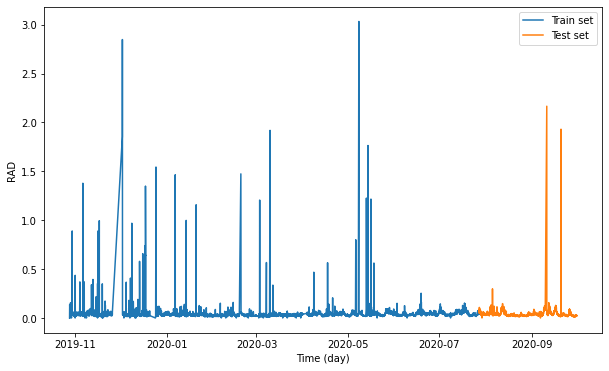

In [ ]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.RMS)
plt.plot(test_dataset.RMS)
plt.xlabel('Time (day)')
plt.ylabel('RAD')
plt.legend(['Train set', 'Test set'], loc='upper right')
plt.savefig('/content/sample_data/2.jpg', format='jpg', dpi=1000)

print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)


In [ ]:
# Split train data to X and y
X_train = train_dataset.drop('RAD', axis = 1)
y_train = train_dataset.loc[:,['RAD']]

# Split test data to X and y
X_test = test_dataset.drop('RAD', axis = 1)
y_test = test_dataset.loc[:,['RAD']]

In [ ]:
# Transform X_train, y_train, X_test and y_test

# Different scaler for input and output
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [ ]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
        
    return np.array(Xs), np.array(ys)


TIME_STEPS = 30

X_test, y_test = create_dataset(test_x_norm, test_y_norm, TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_train.shape)

X_train.shape:  (1970, 30, 9)
y_train.shape:  (7970, 1)
X_test.shape:  (1970, 30, 9)
y_test.shape:  (7970, 1)


In [ ]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    # First layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Second layer of BiLSTM
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    # First layer of LSTM
    model.add(m (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Second layer of LSTM
    model.add(m (units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model


# BiLSTM
model_bilstm = create_model_bilstm(64)

# GRU and LSTM 
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

In [ ]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)

    # shuffle = False because the order of the data matters
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 32, shuffle = False, callbacks = [early_stop])
    return history

history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/100
200/200 [==============================] - 21s 77ms/step - loss: 0.0431 - val_loss: 0.0283
Epoch 2/100
200/200 [==============================] - 13s 66ms/step - loss: 0.0150 - val_loss: 0.0247
Epoch 3/100
200/200 [==============================] - 13s 65ms/step - loss: 0.0131 - val_loss: 0.0258
Epoch 4/100
200/200 [==============================] - 15s 73ms/step - loss: 0.0126 - val_loss: 0.0261
Epoch 5/100
200/200 [==============================] - 15s 73ms/step - loss: 0.0123 - val_loss: 0.0259
Epoch 6/100
200/200 [==============================] - 15s 73ms/step - loss: 0.0123 - val_loss: 0.0252
Epoch 7/100
200/200 [==============================] - 15s 74ms/step - loss: 0.0122 - val_loss: 0.0243
Epoch 8/100
200/200 [==============================] - 13s 67ms/step - loss: 0.0121 - val_loss: 0.0232
Epoch 9/100
200/200 [==============================] - 13s 64ms/step - loss: 0.0121 - val_loss: 0.0222
Epoch 10/100
200/200 [==============================] - 13s 66ms/step - l

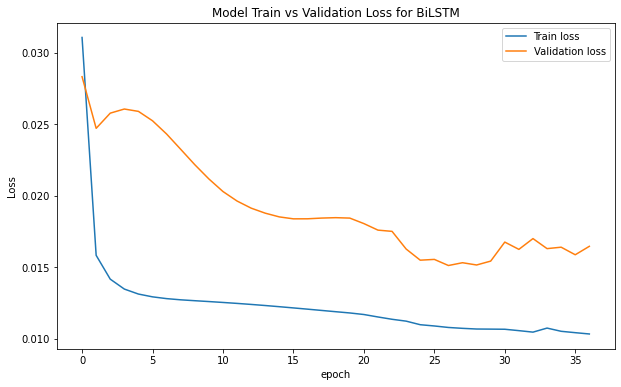

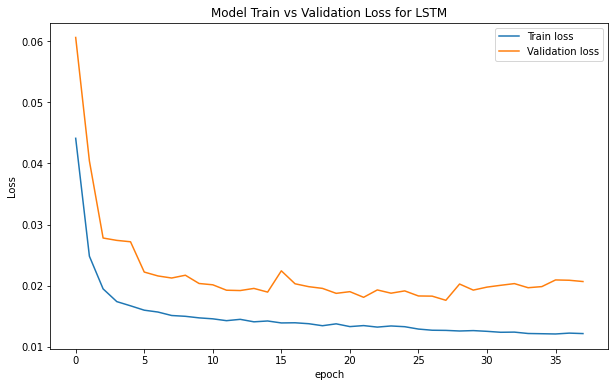

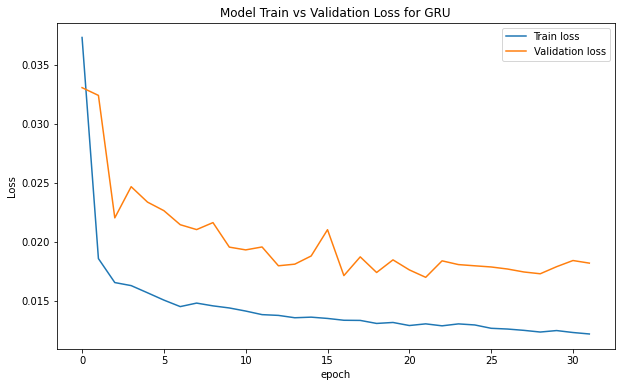

In [ ]:
def plot_loss (history, model_name):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Train vs Validation Loss for ' + model_name)
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')

plot_loss (history_bilstm, 'BiLSTM')
plot_loss (history_lstm, 'LSTM')
plot_loss (history_gru, 'GRU')

In [ ]:
# Note that I have to use scaler_y
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

# Prediction

In [ ]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction

prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)


PLOT FUTUE PREDICTION

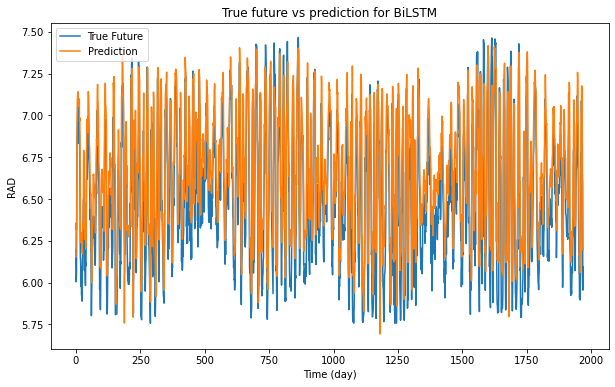

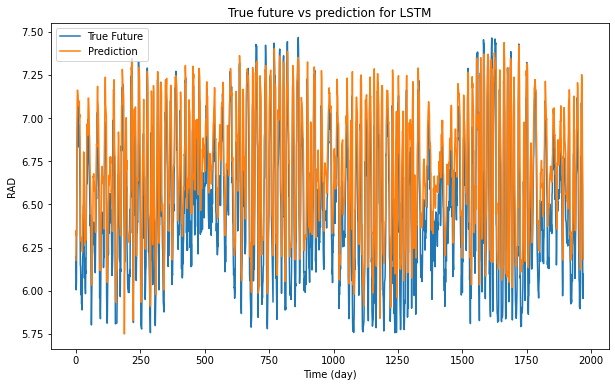

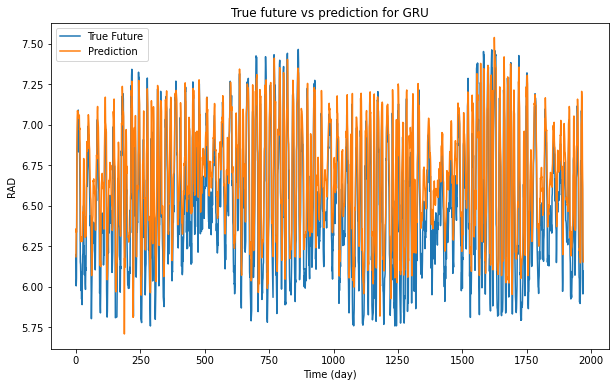

In [ ]:
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='True Future')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('True future vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('RAD')
    
    
plot_future(prediction_bilstm, 'BiLSTM', y_test)
plot_future(prediction_lstm, 'LSTM', y_test)
plot_future(prediction_gru, 'GRU', y_test)

In [ ]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()

    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')


evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')


Bidirectional LSTM:
Mean Absolute Error: 0.2002
Root Mean Square Error: 0.2454

LSTM:
Mean Absolute Error: 0.2249
Root Mean Square Error: 0.2686

GRU:
Mean Absolute Error: 0.2096
Root Mean Square Error: 0.2532



FORECAST 10 YEARS

In [ ]:
# Import climate data projection
newinput = pd.read_csv('https://raw.githubusercontent.com/christianbangarna/IDSL3bulan/main/IDSL-307_data10-2.csv', parse_dates=['Time(UTC)'], index_col = 'Time(UTC)')
 
# Order of the variable are important
X_new = newinput.loc['2019-10-28 05:56:26':'2025-10-28 05:56:26',:] 
X_new = X_new.drop('Lev RAD (m)', axis = 1)
X_new

,Panel (V),rms (m),Sensor Temp (C),Temperature (C),Alert,Alert Signal,Battery (V),Forecast 30 (m),Forecast 300 (m)
Time(UTC),,,,,,,,,
2020-10-01 15:55:28,-5.5,0.021,52.6,-80.999,0.0,0.016,12.215,6.741,6.757
2020-10-01 16:11:03,-5.5,0.026,53.2,-80.999,0.0,0.008,12.203,6.609,6.617
2020-10-01 16:16:44,-5.5,0.026,52.6,-80.999,0.0,0.045,12.207,6.608,6.563
2020-10-01 16:54:52,-5.5,0.025,52.6,-80.999,0.0,0.043,12.208,6.325,6.368
2020-10-01 17:04:03,-5.5,0.023,52.1,-80.999,0.0,0.015,12.204,6.337,6.323
...,...,...,...,...,...,...,...,...,...
2021-02-01 18:23:48,-5.5,0.039,51.5,-80.999,0.0,0.024,12.053,7.077,7.101
2021-02-01 18:53:38,-5.5,0.037,51.0,-80.999,0.0,0.004,12.040,6.877,6.881
2021-02-01 18:54:11,-5.5,0.037,51.0,-80.999,0.0,0.066,12.039,6.947,6.881


In [ ]:
# Plot histoy and future data
def plot_history_future(y_train, prediction, model_name):
    
    plt.figure(figsize=(10, 6))
    
    range_history = len(y_train)
    range_future = list(range(range_history, range_history + len(prediction)))

    plt.plot(np.arange(range_history), np.array(y_train), label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')

    plt.title('History and prediction for ' + model_name)
    plt.legend(loc='upper right')
    plt.xlabel('Time (day)')
    plt.ylabel('RAD')

(4991, 9)


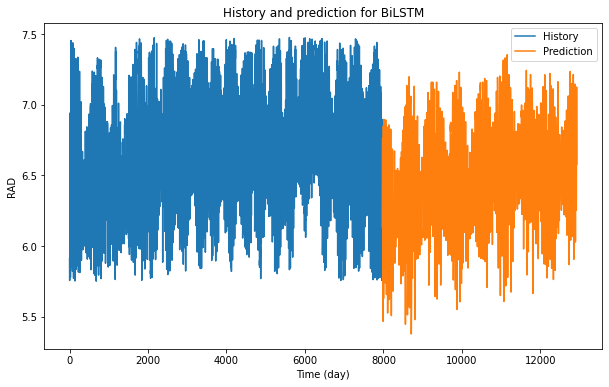

In [ ]:
def forecast(X_input, time_steps):
    # Scale the unseen input with the scaler fitted on the training data
    X = input_scaler.transform(X_input)
    # Reshape unseen data to a 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        
    X_transformed = np.array(Xs)

    # Make prediction for unseen data using LSTM model 
    prediction = model_bilstm.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual
testing = input_scaler.transform(X_new)
print(testing.shape)
prediction = forecast(X_new, TIME_STEPS)
plot_history_future(y_train, prediction,'BiLSTM')